<a href="https://colab.research.google.com/github/Selva-Subramanian/Yes_Bank_Closing_Price_Prediction/blob/main/YES_BANK_STOCK_PRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the
news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting
to see how that impacted the stock prices of the company and whether Time series models
or any other predictive models can do justice to such situations. This dataset has monthly
stock prices of the bank since its inception and includes closing, starting, highest, and lowest
stock prices of every month. The main objective is to predict the stock’s closing price of the
month.

In [1]:
# mount drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing the required libraries
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from datetime import datetime                    # to convert to date

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [3]:
# load the dataset
working_dir_path = "/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/CP2 - Supervised - Regression/"
df = pd.read_csv(working_dir_path + "data_YesBank_StockPrices.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [5]:
# let's look at the details of our features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


We have a total of 185 entries <br>
No missing values <br>
Date column is of 'object' datatype let's convert it to 'datatime' 

In [6]:
# convert string object to datetime object
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%b-%y"))

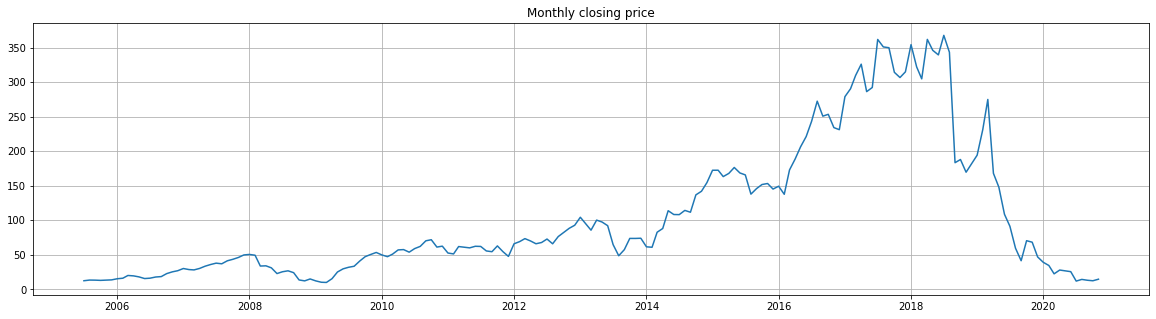

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df.Date, df.Close)
plt.title("Monthly closing price")
plt.grid(True)
plt.show()

In [8]:
# import required metrics 

from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### A moving average much better than a naive forecast ($\hat{y}_t = y_{t-1}$). A **moving average** is the average of previous $k$ values. <br>  $\hat{y}_t = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [9]:
# function for calculating moving average

def moving_average(series, n ):
  
  """
  Calculate average of last n observation
  """
  
  return np.average(series[-n:])

moving_average(df['Close'],12) # prediction for next month closing price using observed previous 12 months data

24.175833333333333

### Unfortunately we can make only one prediction, to make further predictions we need to have the actual observed values. However moving average can be used to identify the trends by smoothing the time series using a pandas implementation [`DataFrame.rolling(window).mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html).

In [10]:
# function for plotting moving average

def ma(series, window, plot_intervals=False):

  """
  series - dataframe column with timeseries
  window - rolling window size
  """

  rolling_mean = series.rolling(window=window).mean()

  plt.figure(figsize=(20,5))
  plt.title('Moving average \n window size = {}'.format(window))
  plt.plot(df['Date'], rolling_mean, "g", label = "Rolling mean trend")

  # plotting confidence intervals
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window] - rolling_mean[window:])
    lower_bound = rolling_mean - (mae + deviation)
    upper_bound = rolling_mean + (mae + deviation)
    plt.plot(df['Date'], lower_bound, "r--", label = "Upper/Lower bounds")
    plt.plot(df['Date'], upper_bound, "r--")
  
  plt.plot(df['Date'], series, label = "Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)

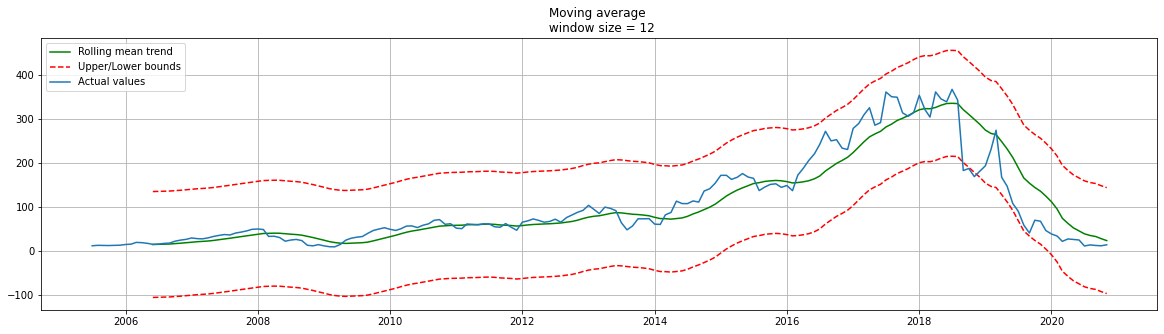

In [11]:
# plotting 12 months moving average 

ma(df['Close'],12, plot_intervals=True) # smoothing by previous 12 months

In [12]:
# function that returns weighted moving average
def wma(series, weights):
  """
  Calculate weighted moving average of the series
  """
  result = 0.0
  for w in range(len(weights)):
    result += series.iloc[-w-1] * weights[w]
    return float(result)

wma(df['Close'], weights = [0.5, 0.3, 0.2])

7.335

### Now let's extend this concept of weighted averages to exponentially weighted moving averages

### **Exponentially weighted moving averages** weights all the available observations while exponentially decreasing the weights as we move back $k$ values 

## $$\hat{y}_{t+1} = \alpha \cdot y_t + \alpha(1-\alpha) \cdot y_{t-1} + \alpha(1-\alpha)^2 \cdot y_{t-2} + \alpha(1-\alpha)^3 \cdot y_{t-3} + .... $$

## $$ \hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat{y}_t $$

In [29]:
def exponential_smoothing(series, alpha):
  """
  series - dataframe column with timeseries
  alpha - smoothing parameter
  """
  result = [series[0]]
  for n in range(len(series)):
    result.append(alpha * series[n] + (1 - alpha) * result[n-1])
  return result

In [30]:
exponential_smoothing(df['Close'], 0.9)

[12.46,
 12.46,
 13.324,
 13.216000000000001,
 13.0234,
 13.390600000000001,
 13.64134,
 15.13606,
 15.872134,
 19.585606,
 19.1282134,
 18.1855606,
 15.970821339999999,
 16.36255606,
 17.653082134,
 18.250255606,
 22.267308213400003,
 24.6130255606,
 26.49973082134,
 29.605302556060003,
 28.416973082134,
 28.286530255606,
 30.120697308213398,
 32.9876530255606,
 35.394069730821336,
 37.43576530255606,
 36.830406973082134,
 40.967576530255606,
 42.81504069730821,
 45.65875765302556,
 49.11050406973082,
 50.051875765302555,
 49.389050406973084,
 35.380187576530254,
 35.59290504069731,
 31.555018757653023,
 24.12429050406973,
 26.060501875765304,
 26.55942905040697,
 24.323050187576527,
 14.877942905040696,
 13.466305018757653,
 15.014794290504069,
 12.362630501875765,
 10.735479429050407,
 10.218263050187577,
 14.97854794290504,
 23.629826305018756,
 28.209854794290504,
 31.099982630501877,
 32.92598547942905,
 40.00099826305019,
 45.8715985479429,
 49.513099826305016,
 52.6561598547942